# Four-point rim bending test

In a four-point bending test, the rim is supported at 3 and 9 o'clock and loaded at 12 and 6 o'clock with a force $P$. A "dummy torque" $Q$ is applied at each point in the same sense as the rotation of the cross-section. Free-body diagrams of the complete rim and the upper section are shown below.

![schematic](https://raw.githubusercontent.com/dashdotrobot/rim-testing/master/4-pt-bend-figures-01.png)

The symmetry of the problem gives us the following conditions:
$$V_1 = -V_2$$
$$T_1 = T_2$$
$$M_1 = M_2$$

Sum of forces in the $z$ direction gives
$$\sum F_z = V_1 - V_2 - P=0$$
$$V_1 = \frac{P}{2}$$

Sum of moments at the right end about the y-axis gives
$$\sum_{(2)} M_y = -T_1-T_2+2V_1 R-PR=0$$
$$T_1 = T_2 = 0$$

Sum of moments at the right end about the x-axis gives
$$\sum_{(2)} M_x = M_1+M_2-PR-Q=0$$
$$M_1 = \frac{PR}{2} + \frac{Q}{2}$$

The internal forces can now be determined by making a cut at an arbitrary location $\theta$.

![schematic2](https://raw.githubusercontent.com/dashdotrobot/rim-testing/master/4-pt-bend-figures-02.png)

In [1]:
%matplotlib inline
from sympy import *
import matplotlib.pyplot as pp
init_printing()

t, m, P, Q, theta, R = symbols('t m P Q theta, R', real=true)
EI, GJ = symbols('EI GJ', real=true, positive=true)

# Internal moment and torque from statics

In [2]:
eq1 = t*sin(theta) - m*cos(theta) + P*R/2*(1 - sin(theta)) + Q/2
eq2 = t*cos(theta) + m*sin(theta) + P*R/2*(1 - cos(theta))

s_statics = solve([eq1, eq2], [t, m])

t = s_statics[t]
m = s_statics[m]

# Get stiffness from Castigliano's method

In [3]:
# Strain energy in half the rim
U = R*integrate(m**2/EI + t**2/GJ, (theta, 0, pi/2))

u0 = diff(U, P).subs(Q, 0).simplify()
phi0 = diff(U, Q).subs(Q, 0).simplify()

## Displacement and rotation at load point

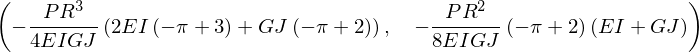

In [4]:
u0, phi0

# Approximation - 2nd mode

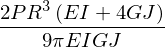

In [5]:
n = symbols('n')
k_bend = pi*EI/R**3 * (n**2-1)**2
k_tors = pi*GJ/R**3 * (n**2-1)**2*n**2

k_rim_2 = (k_bend*k_tors/(k_bend + k_tors)).subs(n, 2).simplify()
u0_2 = 8*P / k_rim_2

u0_2

In [6]:
mu = symbols('mu')

(1 - u0_2 / u0).subs([(EI, 1), (GJ, 0.001)]).evalf()